In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm

%matplotlib inline

In [2]:
import matplotlib as mpl

In [3]:
import vehicleDetection

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
from importlib import reload

In [5]:
import vehicleDetection.drawing
reload(vehicleDetection.drawing)

<module 'vehicleDetection.drawing' from '/mnt/wdblue/Dropbox/Projects/Vehicle Detection/vehicleDetection/drawing.py'>

In [6]:
import vehicleDetection.temporal
reload(vehicleDetection.temporal)

<module 'vehicleDetection.temporal' from '/mnt/wdblue/Dropbox/Projects/Vehicle Detection/vehicleDetection/temporal.py'>

# Load and look at the training data.

In [7]:
images, classes = vehicleDetection.data.getData(numLighter=0, numFlip=0)
imageWindows = images
windowClasses = classes

HBox(children=(IntProgress(value=0, max=6726), HTML(value='')))

# Train the classifier on the full dataset with the best classifier parameters.

In [8]:
detectorNoAug = vehicleDetection.detector.Detector()

Got scalar parameter (C). Assuming no CV requested.


In [16]:
indices = np.arange(len(images))
np.random.shuffle(indices)
# Fit time here is roughly linear in n.
n = 4096
imageWindows = [images[i] for i in indices[:n]]
windowClasses = [classes[i] for i in indices[:n]]

In [17]:
spi = (3*60 + 59) / (6053 + 673)
print('Estimated fit/test runtime is %.3g minutes.' % (len(imageWindows) * spi / 60.,))

Estimated fit/test runtime is 2.43 minutes.


In [18]:
%%time
detectorNoAug.fit(
    imageWindows,
    windowClasses,
)

3686-image train accuracy of clf =  0.993488876831
410-image test accuracy of clf =  0.987804878049
CPU times: user 1min, sys: 192 ms, total: 1min
Wall time: 1min


# Run the detector on the test video.

In [19]:
maxf = np.inf
testh = vehicleDetection.temporal.HeatVideo(maxFrames=maxf)

In [20]:
testh.go(detectorNoAug);

Number of support vectors for each class: [346 305]


HBox(children=(IntProgress(value=0, description='processing: ', max=38), HTML(value='')))

In [21]:
improvedCoolingKwargs = dict(
    heatTransferCoefficient = 1,
    heatCapacity = 20,
    powerFactor = 20,
    coolingRate = 10,
)
tempThresh = 20

In [22]:
%%time
testh.coolingKwargs.update(improvedCoolingKwargs)
testh.persist(tempThresh)
testh.video();

HBox(children=(IntProgress(value=0, description='persist bboxes: ', max=38), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='test_video-detected.mp4: ', max=1), HTML(value='')))


CPU times: user 3.01 s, sys: 248 ms, total: 3.26 s
Wall time: 8.5 s


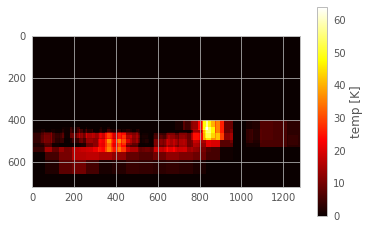

In [23]:
T = testh.temperatures[-1]
fig, ax = plt.subplots()
im = ax.imshow(T, origin='upper', cmap='hot')
fig.colorbar(im, label='temp [K]')

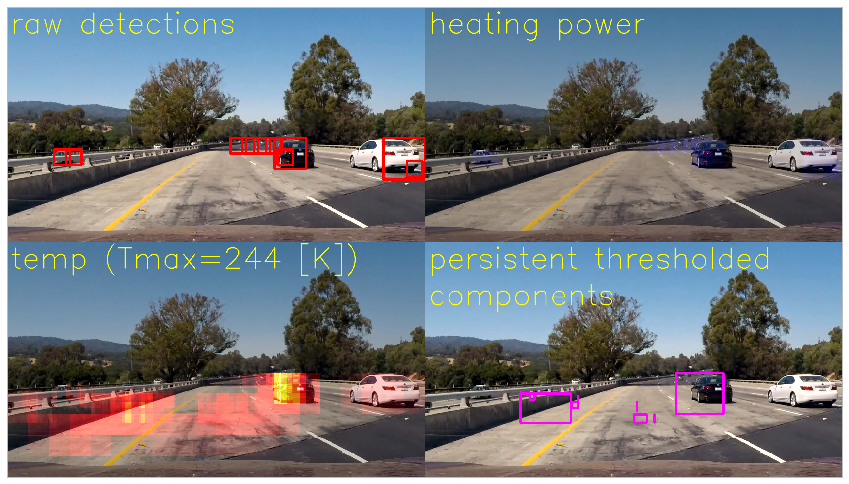

In [24]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(testh.vidFrame)
ax.set_xticks([])
ax.set_yticks([]);

## Run the detector on the project video.

In [25]:
maxf = np.inf
projh = vehicleDetection.temporal.HeatVideo(fpath='../../../data/vehicleDetection/project_video.mp4', maxFrames=maxf)

In [26]:
# # Delete empty frames at beginning.
# projh.inputFrames = projh.inputFrames[120:]

In [27]:
projh.go(detectorNoAug);

Number of support vectors for each class: [346 305]


HBox(children=(IntProgress(value=0, description='processing: ', max=1140), HTML(value='')))

In [ ]:
%%time
projh.coolingKwargs.update(improvedCoolingKwargs)
projh.persist(tempThresh)
projh.video();

In [29]:
break

SyntaxError: 'break' outside loop (<ipython-input-29-6aaf1f276005>, line 1)

Try again on the agumented data.

In [ ]:
images, classes = vehicleDetection.data.getData()

In [ ]:
detectorAug = vehicleDetection.detector.Detector()

In [ ]:
spi = (3*60 + 59) / (6053 + 673)
print('Estimated fit/test runtime is %.3g minutes.' % (len(images) * spi / 60.,))

In [ ]:
%%time
detectorAug.fit(
    images,
    classes,
)

In [ ]:
testh.go(detectorAug)

In [ ]:
testh.persist(20)
testh.video(label='-augmented')

In [ ]:
projh.go(detectorAug)

In [ ]:
projh.persist(20)
projh.video(label='-augmented')